<a href="https://colab.research.google.com/github/femioladosu/Assignment2/blob/main/N_SWKMOB_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import io
from numpy.linalg import norm

OUR ALG: PREPROCESSING
1. For each POI calculate the CosinSim of the Feature vector with respect to an ORIGIN feature vector v =[0,0,0,0,0,0,.....etc]
2. Insert each POI into a sorted list based on the CosinSim

OUR ALG: Real time
1. Given the CAR lon and lat position, calc cosinSim with respect to origin
2. Collect all POIs who cosinSim equal or within some threashold +-T.  of the CAR's cosinSim to origin calculated in Step 1
3. conduct a simple geo query. on the results of step 2 
4. do KNN on result of step 3
5. conduct auction on the results of Step 4


Look into extendible hashing. It may be a way to keep track of a set of buckets. The issue is are the contents in the buckets sorted. EX - if you have two buckets of max size 5, and 10 items to insert. You expect that 5 items will be in each bucket, but sorted, such that the first bucket has 1 - 5, and the second has 6 - 10. Once you add the 11th item, a third bucket is created and the contents are equally distributed  across the three buckets, while maintaining sorted order.  I think the key to this is the hash function which may be tricky, if it can be done at all.

Another option could be to use a B-tree.

So that we don't get bogged down in this, because we are still trying to proof this out, we may want to just keep a sorted list, then play around with a tuning parameter t (the max number of items in the bucket) that we can adjust and retry to find the best t. Given a value t, we can divide this by the number of items to figure out the number of bucket then create them before we run our simulation.



I don't think what I sent changes anything. I'm trying to figure out how to keep a sorted list of ads based on cossim score, and group similar ones into a bucket so that when we need to identify a group of ads to do KNN we choose a bucket and reduce the search space quickly.

SortArrays sorts the car and ad location in increasing order

In [ ]:
def sortArrays(arr):
 
    # Finding the length of array 'arr'
    length = len(arr)
 
    # Sorting using a single loop
    j = 0
 
    while j < length - 1:
 
        # Checking the condition for two
        # simultaneous elements of the array
        if (arr[j] > arr[j + 1]):
 
            # Swapping the elements.
            temp = arr[j]
            arr[j] = arr[j + 1]
            arr[j + 1] = temp
 
            # updating the value of j = -1
            # so after getting updated for j++
            # in the loop it becomes 0 and
            # the loop begins from the start.
            j = -1
        j += 1
 
    return arr

Coordinates for origin, ads, cars

In [ ]:
originPoint = (51.477928, -0.001545)
adsArr = [(-76.99204394,	38.88109181),(-77.0348295,	38.90158355),(-76.96729234,	38.85865548),(-77.02596703,	38.91653647),(-77.04258764,	38.89570284),(-77.03296842,	38.89598548),
(-77.0193809,	38.84509427),(-77.01973033,	38.82818543),(-77.01397699,	38.8699774),(-77.04115756,	38.89395195),(-77.01551963,	38.90075408),(-77.01036084,	38.89848364),(-77.02098368,	38.9245365),
(-77.01815468,	38.84649366),(-77.01534446,	38.84529135),(-77.02310307,	38.90359496),(-77.03821122,	38.89913186),(-77.03820057,	38.89927131),(-77.03821591,	38.89971434),(-77.03821591,	38.89971434),
(-77.03671446,	38.98523456),(-77.00477786,	38.89175349),(-77.00477786,	38.89175349),(-77.02259825,	38.90148449),(-77.02259825,	38.90148449),(-77.02259825,	38.90148449),(-77.0343357,	38.89815043),
(-77.02550918,	38.88796215),(-77.04932234,	38.91034301),(-77.04799222,	38.9132156),(-77.00130077,	38.94163569),(-77.00134541,	38.94185207),(-77.03591515,	38.90938752),(-77.03824811,	38.90172986),
(-77.04600262,	38.89814804),(-77.02414933,	38.83112722),(-77.04133332,	38.904446),(-77.01016401,	38.81889766),(-76.98582868,	38.84560742),(-76.96989267,	38.91241056),(-76.9739504,	38.90506604),
(-76.97388038,	38.90485288),(-76.97274118,	38.90369928),(-76.99207261,	38.94359518),(-77.01793299,	38.92194937),(-77.00695631,	38.93655562),(-77.00695631,	38.93655562),(-77.03601971,	38.95344028),
(-77.00739036,	38.85887135),(-77.01141082,	38.83737112),(-77.04621067,	38.89756899),(-77.00402316,	38.85856135),(-77.01852853,	38.92161381),(-77.08990371,	38.93773125),(-77.0302909,	38.91796325),
(-76.95560701,	38.86435729),(-77.02787832,	38.95882503),(-76.99659131,	38.90276545),(-77.02087386,	38.94140376),(-77.05860248,	38.90668322),(-77.04064606,	38.90905428),(-77.05993084,	38.90456919),
(-77.05931965,	38.9045159),(-77.03822209,	38.80539261),(-77.07537486,	38.96367185),(-77.06994919,	38.90755827),(-76.99510047,	38.94054001),(-77.00557526,	38.89286103),(-77.01237526,	38.85883876)]
carsArr = [(-76.9844789,38.91207262),(-76.99473385,38.93963214),(-77.01918055,38.91532571),(-77.05428362,38.92546994),(-77.02675325,38.91880657)]


# Read all PoIs and car locations from a file into respective arrays

1. Calculate cosinesim of cars from origin
2. multiply to shift decimals
3. sort using sortArrays
4. print

In [ ]:
cosine_POI = []    

for points in adsArr:
    newPOI = np.dot(originPoint,points) / (norm(originPoint)*norm(points))
#    print (newPOI)
    cosine_POI.append( int (newPOI * 10000000000000000) )


cosine_POI = sortArrays(cosine_POI)
print(cosine_POI)

[-8931092192584114, -8929804302251991, -8929596205316377, -8929562932932239, -8928972585624837, -8928799959100544, -8928705907131332, -8928695880254591, -8927994513774089, -8927986888045617, -8927875719548498, -8927810947261422, -8927512879541402, -8927078117009408, -8927034827909875, -8926986866927018, -8926985141017645, -8926981718903778, -8926969822219289, -8926953254855802, -8926945766347446, -8926941784608338, -8926851941628913, -8926747285667047, -8926724016033203, -8926717264384897, -8926696972011234, -8926696972011234, -8926678539610727, -8926603768032922, -8926549774380171, -8926530106321922, -8926478120612387, -8926462946417976, -8926400357584745, -8926318757052143, -8926297724841148, -8926280775957546, -8926280775957546, -8926247901685251, -8926246701606854, -8926246701606854, -8926246701606854, -8926191818509266, -8926160174193664, -8926141725311044, -8926114028598120, -8926098390651082, -8925659455371676, -8925624115615138, -8925574160034193, -8925211993978982, -8925182302

1. Calculate cosinesim of cars from origin
2. multiply to shift decimals
3. sort using sortArrays
4. print

In [ ]:
cosine_Car = []

for cars in carsArr:
    cosine_Car.append( int ( np.dot(originPoint,cars) / (norm(originPoint)*norm(cars)) * 10000000000000000 )  )


cosine_Car = sortArrays(cosine_Car)
print(cosine_Car)

[-8925874605514796, -8925536770713366, -8925520662948003, -8924854240669270, -8923809974043876]


1. Divide ads array into buckets in groups of 10

In [ ]:
cosine_PP = []
start = 0
end = len(cosine_POI)
step = 10
for i in range(start, end, step):
    x = i
    cosine_PP.append(cosine_POI[x:x+step])
    
    
#print(len(cosine_PP))
print (cosine_PP)

[[-8931092192584114, -8929804302251991, -8929596205316377, -8929562932932239, -8928972585624837, -8928799959100544, -8928705907131332, -8928695880254591, -8927994513774089, -8927986888045617], [-8927875719548498, -8927810947261422, -8927512879541402, -8927078117009408, -8927034827909875, -8926986866927018, -8926985141017645, -8926981718903778, -8926969822219289, -8926953254855802], [-8926945766347446, -8926941784608338, -8926851941628913, -8926747285667047, -8926724016033203, -8926717264384897, -8926696972011234, -8926696972011234, -8926678539610727, -8926603768032922], [-8926549774380171, -8926530106321922, -8926478120612387, -8926462946417976, -8926400357584745, -8926318757052143, -8926297724841148, -8926280775957546, -8926280775957546, -8926247901685251], [-8926246701606854, -8926246701606854, -8926246701606854, -8926191818509266, -8926160174193664, -8926141725311044, -8926114028598120, -8926098390651082, -8925659455371676, -8925624115615138], [-8925574160034193, -8925211993978982, 

In [ ]:
for i in cosine_PP:
    print (i)

[-8931092192584114, -8929804302251991, -8929596205316377, -8929562932932239, -8928972585624837, -8928799959100544, -8928705907131332, -8928695880254591, -8927994513774089, -8927986888045617]
[-8927875719548498, -8927810947261422, -8927512879541402, -8927078117009408, -8927034827909875, -8926986866927018, -8926985141017645, -8926981718903778, -8926969822219289, -8926953254855802]
[-8926945766347446, -8926941784608338, -8926851941628913, -8926747285667047, -8926724016033203, -8926717264384897, -8926696972011234, -8926696972011234, -8926678539610727, -8926603768032922]
[-8926549774380171, -8926530106321922, -8926478120612387, -8926462946417976, -8926400357584745, -8926318757052143, -8926297724841148, -8926280775957546, -8926280775957546, -8926247901685251]
[-8926246701606854, -8926246701606854, -8926246701606854, -8926191818509266, -8926160174193664, -8926141725311044, -8926114028598120, -8926098390651082, -8925659455371676, -8925624115615138]
[-8925574160034193, -8925211993978982, -89251

We are dealing with everything above this for now!
**************************************************
**************************************************

In [ ]:
import numpy as np

# Set the threshold value
T = 0.8

# Generate some random coordinates
coordinates = np.random.rand(10, 2)

print (coordinates)

# Calculate the cosine similarity between every pair of vectors
cosine_similarities = np.dot(coordinates, coordinates.T) / (np.linalg.norm(coordinates, axis=1)[:, np.newaxis] * np.linalg.norm(coordinates, axis=1))

# Collect all coordinates whose cosine similarity is within the threshold +-T
result = []
for i in range(len(coordinates)):
    for j in range(i+1, len(coordinates)):
        if cosine_similarities[i][j] >= T:
            result.append((i, j))

print(result)


[[0.96173228 0.92470252]
 [0.76493705 0.71040634]
 [0.13482755 0.25066048]
 [0.28865575 0.58490755]
 [0.14473007 0.74730953]
 [0.79392917 0.92187003]
 [0.41360941 0.80752075]
 [0.19598756 0.77177861]
 [0.27982301 0.13431794]
 [0.6028149  0.15167051]]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (8, 9)]


In [ ]:
Poi_2_Car = []

for cars in carsArr:
    for points in adsArr:
        newPOI = np.dot(points,cars) / (norm(points)*norm(cars))
        Poi_2_Car.append( newPOI )

Poi_2_Car

[0.9999999351539561,
 0.9999999309341792,
 0.9999998928122092,
 0.9999999854292763,
 -0.46857973247302237,
 0.999999825016285,
 0.9999998181272175,
 0.9999997588628777,
 0.9999999191331683,
 -0.46837524980509293,
 0.9999999774503879,
 0.9999999749347183,
 0.9999999503102915,
 0.9999999997367275,
 -0.4687102635299213,
 0.9999999910393456,
 0.9999999894289446,
 0.9999999719747839,
 0.9999999984571696,
 -0.4687796010518243,
 0.9999999782025832,
 0.9999999757281086,
 0.9999999514299734,
 0.9999999998123135,
 -0.46871341887777657]

In [ ]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['DC_POI.csv']))
df.head()

Saving DC_POI.csv to DC_POI.csv


,X,Y,ALIASNAME
0,-76.992044,38.881092,TYLER ELEMENTARY SCHOOL
1,-77.034830,38.901584,UNITED MINE WORKERS OF AMERICA
2,-76.967292,38.858655,FREDERICK DOUGLASS POST OFFICE
3,-77.025967,38.916536,AFRICAN AMERICAN CIVIL WAR MEMORIAL
4,-77.042588,38.895703,RAWLINS PARK


In [ ]:

#car = (-77.017592, 38.888655)
originPoint = (51.477928, -0.001545)
PoI = (-16.992044,	38.881092	)

cosinePOI = np.dot(originPoint,PoI) / (norm(originPoint)*norm(PoI))
print("Cos Sim: ", cosinePOI)


Cos Sim:  -0.40048166615151354


In [ ]:
car = (-77.017592, 38.888655)

cosineCar = np.dot(originPoint,car) / (norm(originPoint)*norm(car))
print("Cos Sim: ", cosineCar)

Cos Sim:  -0.8926727072052101


Load image of map

In [ ]:
uploaded = files.upload()
img = plt.imread('map.png')

Saving map.png to map.png


Calc the Bounding Box

// BBox = (df['X'].min(), df['X'].max(), df['Y'].min(), df['Y'].max())   // Dynaically create bounding BBox

In [ ]:

BBox = (-77.0265, -77.0056, 38.8870, 38.8984)
print(BBox)

(-77.0265, -77.0056, 38.887, 38.8984)


Plotting POI on map

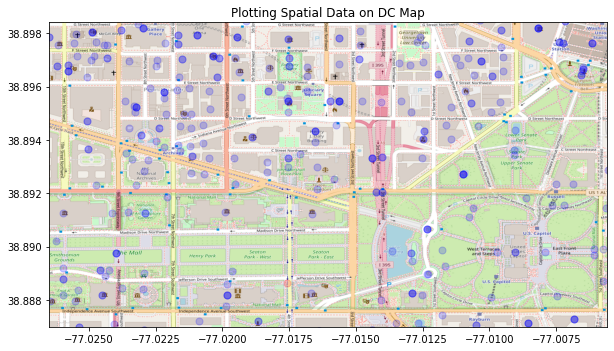

In [ ]:
fig, ax = plt.subplots(figsize = (10,9))
ax.scatter(df.X, df.Y, zorder=1, alpha= 0.2, c='b', s=50)
carX = -77.017592
carY = 38.888655
ax.scatter(carX, carY, zorder=1, alpha= 0.2, c='r', s=50)
ax.set_title('Plotting Spatial Data on DC Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(img, zorder=0, extent = BBox, aspect= 'equal')

Add a single point to represent a car

In [ ]:
carX = -77.967292
carY = 38.858655
ax.scatter(carX, carY, zorder=1, alpha= 0.2, c='r', s=50)


In [ ]:

carX = -77.017592
carY = 38.888655


ax.scatter(carX, carY, zorder=1, alpha= 0.2, c='r', s=50)
ax.plot(carX, carY)
